# Exploring MovieLens : Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np 

from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import stats
from scipy.spatial.distance import pdist

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from itertools import cycle

import string

from collections import Counter

In [32]:
from keras.layers.embeddings import Embedding
from keras.layers import Input, merge
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

## Importing the data

In [3]:
org_ratings = pd.read_csv('data/MovieLens/ratings.csv')
org_movies = pd.read_csv('data/MovieLens/movies.csv')
org_ratings.head(), org_movies.head()

(   userId  movieId  rating   timestamp
 0       1       31     2.5  1260759144
 1       1     1029     3.0  1260759179
 2       1     1061     3.0  1260759182
 3       1     1129     2.0  1260759185
 4       1     1172     4.0  1260759205,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  
 0  Adventure|Animation|Children|Comedy|Fantasy  
 1                   Adventure|Children|Fantasy  
 2                               Comedy|Romance  
 3                         Comedy|Drama|Romance  
 4                                       Comedy  )

In [4]:
users = org_ratings.userId.unique()
movies = org_ratings.movieId.unique()
rating = org_ratings.rating.unique()
len(users), len(movies), len(rating)

(671, 9066, 10)

In [5]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}
movieidx2id = {i:o for i,o in enumerate(movies)}

In [6]:
new_ratings = org_ratings.copy()

new_ratings.movieId = org_ratings.movieId.apply(lambda x: movieid2idx[x])
new_ratings.userId = org_ratings.userId.apply(lambda x: userid2idx[x])

Now, I want to make a 10 by 671 by 9066 matrix. For each depth 1-5, a value 1 is assigned to the 2D matrix if the user has rated a movie by the depth (i.e. x out of 5) or a 0 if not. 

This allows us to deal with the challenge of missing data, as not every user has rated every movie (and sklearn doesn't like missing data). I'll begin by sorting the data, and removing the timestamp (which I won't include in my analysis right now).

In [7]:
new_ratings = new_ratings.drop('timestamp', axis = 1)

Now, I want to split this into a training and validation set, which are 80% and 20% of the total dataset respectively. I can use numpy's randn function to make sure the data is randomly split. 

In [8]:
msk = np.random.rand(len(new_ratings)) < 0.8

train = new_ratings[msk]
valid = new_ratings[~msk]

In [9]:
print(train.shape, valid.shape)
print(train.head())

((80096, 3), (19908, 3))
   userId  movieId  rating
0       0        0     2.5
1       0        1     3.0
2       0        2     3.0
3       0        3     2.0
5       0        5     2.0


Excellent

## Training a neural net

Before simply training a neural net, an additional step is necessary. There is going to be a discrepency between how users rate movies, even if they have similar preferences (eg. one user may give - on average - higher ratings than another) and, in the same vein, there are good movies and bad movies which will receive different scores regardless of a user's preferences. 

This can be represented by a bias layer, which I can create using an embedding layer, which will turn my indices (i.e. userId and movieId) into dense vectors of fixed size. 

In [10]:
# I begin by specifying the input shape, which is the userId and movieId 
# I need to turn this into a tensor, so that's the first thing i'll do 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')

Now that I have these inputs, I want to add an embedding layer **for each of them**; remember, both users and movies have a 'bias'. 

In [11]:
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)

Now that I've added this embedding layer, I can make the rest of my model by merging these two layers. 

In [12]:
x = merge([user_embed, movie_embed], mode='concat')

In [13]:
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_input, movie_input], x)
nn.compile(Adam(0.001), loss='mse')

Awesome! So we have our first neural network. Let's try training it

In [14]:
BASELINE = nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 5s - loss: 2.3765 - val_loss: 0.8768
Epoch 2/20
79845/79845 [==============================] - 5s - loss: 1.3952 - val_loss: 0.8363
Epoch 3/20
79845/79845 [==============================] - 5s - loss: 1.1658 - val_loss: 0.8149
Epoch 4/20
79845/79845 [==============================] - 5s - loss: 0.9822 - val_loss: 0.8008
Epoch 5/20
79845/79845 [==============================] - 5s - loss: 0.8461 - val_loss: 0.7919
Epoch 6/20
79845/79845 [==============================] - 5s - loss: 0.7743 - val_loss: 0.7852
Epoch 7/20
79845/79845 [==============================] - 5s - loss: 0.7441 - val_loss: 0.7885
Epoch 8/20
79845/79845 [==============================] - 5s - loss: 0.7255 - val_loss: 0.7865
Epoch 9/20
79845/79845 [==============================] - 5s - loss: 0.7140 - val_loss: 0.7837
Epoch 10/20
79845/79845 [==============================] - 5s - loss: 0.7103 - val_loss: 0.7858

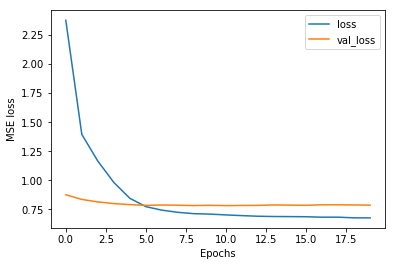

In [15]:
plt.plot(BASELINE.history['loss'], label = 'loss')
plt.plot(BASELINE.history['val_loss'], label = 'val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

Hm. So it's quite clear that I start overfitting the data after the 6th epoch, after which the validation loss starts increasing again. 

There are a few things I can do to improve my loss; let's begin by investigating other collaborative filtering architectures. 

### Trying different architectures

There are a few layers designed specifically for recommender systems, so I'm going to try them. Specifically, I'm going to experiment with GRU and LTSM layers, which are Recurrant layers. 

To begin with, I'm going to implement these in single layers. 

### GRU layers

In [42]:
# Single layer GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')
 
x = GRU(1)(x)

GRU_model = Model([user_input, movie_input], x)

In [43]:
GRU_model.compile(Adam(0.01), loss='mse')

In [45]:
GRU_history = GRU_model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=8, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80065 samples, validate on 19939 samples
Epoch 1/8
80065/80065 [==============================] - 8s - loss: 7.6797 - val_loss: 7.6241
Epoch 2/8
80065/80065 [==============================] - 8s - loss: 7.5819 - val_loss: 7.6255
Epoch 3/8
80065/80065 [==============================] - 8s - loss: 7.5823 - val_loss: 7.6258
Epoch 4/8
80065/80065 [==============================] - 8s - loss: 7.5823 - val_loss: 7.6252
Epoch 5/8
80065/80065 [==============================] - 8s - loss: 7.5859 - val_loss: 7.6388
Epoch 6/8
80065/80065 [==============================] - 8s - loss: 7.5981 - val_loss: 7.6380
Epoch 7/8
80065/80065 [==============================] - 8s - loss: 7.5980 - val_loss: 7.6380
Epoch 8/8
80065/80065 [==============================] - 8s - loss: 7.5980 - val_loss: 7.6380


Well this is horribly worse than my dense layer. Let's try increasing the complexity of the model. 

In [59]:
# Multi layer GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.3)(x)
x = GRU(70)(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
GRU_nn = Model([user_input, movie_input], x)
GRU_nn.compile(Adam(0.001), loss='mse')

In [60]:
GRUnn_history = GRU_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80065 samples, validate on 19939 samples
Epoch 1/10
80065/80065 [==============================] - 10s - loss: 2.1601 - val_loss: 0.8425
Epoch 2/10
80065/80065 [==============================] - 10s - loss: 1.2158 - val_loss: 0.7968
Epoch 3/10
80065/80065 [==============================] - 10s - loss: 1.0784 - val_loss: 0.7946
Epoch 4/10
80065/80065 [==============================] - 10s - loss: 0.9466 - val_loss: 0.7842
Epoch 5/10
80065/80065 [==============================] - 10s - loss: 0.8553 - val_loss: 0.7829
Epoch 6/10
80065/80065 [==============================] - 10s - loss: 0.7878 - val_loss: 0.7814
Epoch 7/10
80065/80065 [==============================] - 10s - loss: 0.7488 - val_loss: 0.7780
Epoch 8/10
80065/80065 [==============================] - 10s - loss: 0.7225 - val_loss: 0.7698
Epoch 9/10
80065/80065 [==============================] - 10s - loss: 0.7049 - val_loss: 0.7661
Epoch 10/10
80065/80065 [==============================] - 10s - loss: 0.6941 - val_lo

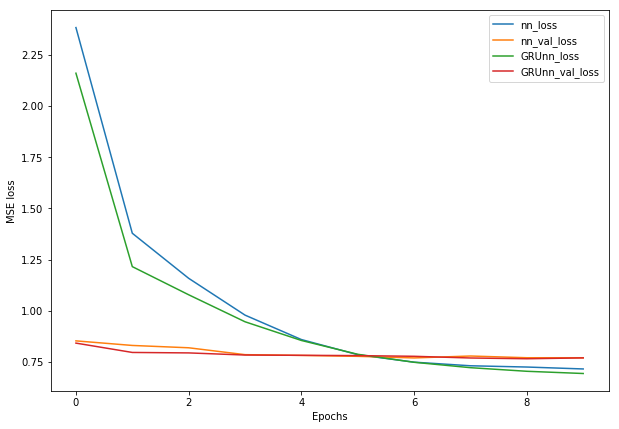

In [68]:
plt.clf()
plt.plot(nn_history.history['loss'], label = 'nn_loss')
plt.plot(nn_history.history['val_loss'], label = 'nn_val_loss')
plt.plot(GRUnn_history.history['loss'], label = 'GRUloss')
plt.plot(GRUnn_history.history['val_loss'], label = 'GRUval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

Now, instead of a single directional GRU layer, lets use a bi-directional GRU layer

In [13]:
# Multi layer bi-directional GRU model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.3)(x)
x_fwd = GRU(70)(x)
x_bwd = GRU(70, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
x = Dense(1)(x)
GRU_bdir = Model([user_input, movie_input], x)
GRU_bdir.compile(Adam(0.001), loss='mse')

In [14]:
GRUbdir_history = GRU_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=10, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79739 samples, validate on 20265 samples
Epoch 1/10
79739/79739 [==============================] - 17s - loss: 1.7895 - val_loss: 0.8205
Epoch 2/10
79739/79739 [==============================] - 17s - loss: 1.0371 - val_loss: 0.8021
Epoch 3/10
79739/79739 [==============================] - 17s - loss: 0.9505 - val_loss: 0.7970
Epoch 4/10
79739/79739 [==============================] - 16s - loss: 0.8901 - val_loss: 0.7973
Epoch 5/10
79739/79739 [==============================] - 16s - loss: 0.8354 - val_loss: 0.7929
Epoch 6/10
79739/79739 [==============================] - 16s - loss: 0.7907 - val_loss: 0.7964
Epoch 7/10
79739/79739 [==============================] - 16s - loss: 0.7570 - val_loss: 0.7879
Epoch 8/10
79739/79739 [==============================] - 16s - loss: 0.7313 - val_loss: 0.7841
Epoch 9/10
79739/79739 [==============================] - 16s - loss: 0.7100 - val_loss: 0.7778
Epoch 10/10
79739/79739 [==============================] - 17s - loss: 0.6926 - val_lo

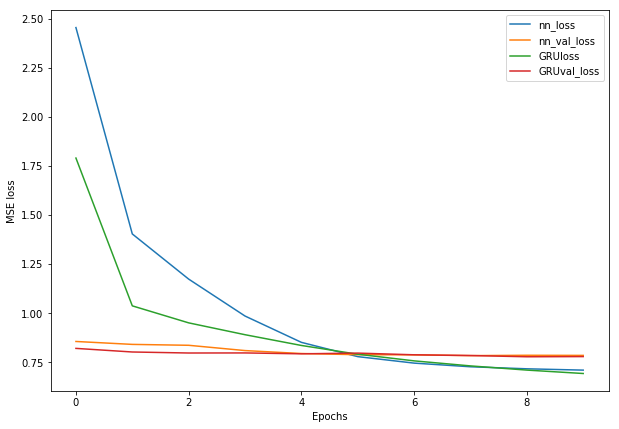

In [22]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(nn_history.history['loss'], label = 'nn_loss')
plt.plot(nn_history.history['val_loss'], label = 'nn_val_loss')
plt.plot(GRUbdir_history.history['loss'], label = 'GRUloss')
plt.plot(GRUbdir_history.history['val_loss'], label = 'GRUval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

### LSTM layers

In [50]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x = LSTM(70)(x)
x = Dropout(0.75)(x)
BatchNormalization()
x = Dense(1)(x)
LSTM_nn = Model([user_input, movie_input], x)
LSTM_nn.compile(Adam(0.001), loss='mse')

In [51]:
LSTM_history = LSTM_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=15, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79739 samples, validate on 20265 samples
Epoch 1/15
79739/79739 [==============================] - 12s - loss: 2.6672 - val_loss: 0.8742
Epoch 2/15
79739/79739 [==============================] - 12s - loss: 1.2839 - val_loss: 0.8185
Epoch 3/15
79739/79739 [==============================] - 12s - loss: 1.1509 - val_loss: 0.8022
Epoch 4/15
79739/79739 [==============================] - 12s - loss: 1.0285 - val_loss: 0.7961
Epoch 5/15
79739/79739 [==============================] - 12s - loss: 0.9187 - val_loss: 0.7917
Epoch 6/15
79739/79739 [==============================] - 12s - loss: 0.8523 - val_loss: 0.7842
Epoch 7/15
79739/79739 [==============================] - 12s - loss: 0.8032 - val_loss: 0.7869
Epoch 8/15
79739/79739 [==============================] - 12s - loss: 0.7778 - val_loss: 0.7838
Epoch 9/15
79739/79739 [==============================] - 12s - loss: 0.7636 - val_loss: 0.7803
Epoch 10/15
79739/79739 [==============================] - 12s - loss: 0.7513 - val_lo

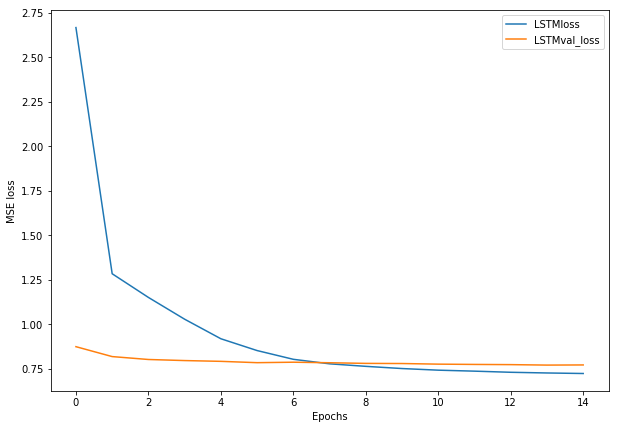

In [52]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(LSTM_history.history['loss'], label = 'LSTMloss')
plt.plot(LSTM_history.history['val_loss'], label = 'LSTMval_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

In [57]:
# Multi layer LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x = LSTM(50)(x)
x = Dropout(0.75)(x)
BatchNormalization()
x = Dense(1)(x)
LSTM50_nn = Model([user_input, movie_input], x)
LSTM50_nn.compile(Adam(0.001), loss='mse')

In [58]:
LSTM50_history = LSTM50_nn.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79739 samples, validate on 20265 samples
Epoch 1/20
79739/79739 [==============================] - 11s - loss: 2.9481 - val_loss: 0.8997
Epoch 2/20
79739/79739 [==============================] - 11s - loss: 1.4144 - val_loss: 0.8350
Epoch 3/20
79739/79739 [==============================] - 11s - loss: 1.2325 - val_loss: 0.8207
Epoch 4/20
79739/79739 [==============================] - 11s - loss: 1.0509 - val_loss: 0.7951
Epoch 5/20
79739/79739 [==============================] - 11s - loss: 0.9326 - val_loss: 0.7891
Epoch 6/20
79739/79739 [==============================] - 11s - loss: 0.8442 - val_loss: 0.7844
Epoch 7/20
79739/79739 [==============================] - 11s - loss: 0.7990 - val_loss: 0.7854
Epoch 8/20
79739/79739 [==============================] - 11s - loss: 0.7750 - val_loss: 0.7804
Epoch 9/20
79739/79739 [==============================] - 11s - loss: 0.7607 - val_loss: 0.7772
Epoch 10/20
79739/79739 [==============================] - 11s - loss: 0.7531 - val_lo

## Bidirectional RNNs

In [24]:
# Bidirectional LSTM model with regularization

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(50)(x)
x_bwd = LSTM(50, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM50_bdir = Model([user_input, movie_input], x)
LSTM50_bdir.compile(Adam(0.001), loss='mse')

In [26]:
LSTM50_history = LSTM50_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 20s - loss: 2.4111 - val_loss: 0.8695
Epoch 2/20
79845/79845 [==============================] - 20s - loss: 1.1725 - val_loss: 0.8187
Epoch 3/20
79845/79845 [==============================] - 20s - loss: 1.0842 - val_loss: 0.8095
Epoch 4/20
79845/79845 [==============================] - 20s - loss: 0.9937 - val_loss: 0.7972
Epoch 5/20
79845/79845 [==============================] - 20s - loss: 0.9140 - val_loss: 0.7948
Epoch 6/20
79845/79845 [==============================] - 19s - loss: 0.8527 - val_loss: 0.7892
Epoch 7/20
79845/79845 [==============================] - 20s - loss: 0.8115 - val_loss: 0.7857
Epoch 8/20
79845/79845 [==============================] - 20s - loss: 0.7822 - val_loss: 0.7826
Epoch 9/20
79845/79845 [==============================] - 20s - loss: 0.7632 - val_loss: 0.7830
Epoch 10/20
79845/79845 [==============================] - 20s - loss: 0.7489 - val_lo

In [14]:
# Bidirectional LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
x = Dense(1)(x)
LSTM40nbn_bdir = Model([user_input, movie_input], x)
LSTM40nbn_bdir.compile(Adam(0.001), loss='mse')
LSTM40nbn_history = LSTM40nbn_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80096 samples, validate on 19908 samples
Epoch 1/20
80096/80096 [==============================] - 18s - loss: 2.5601 - val_loss: 0.8619
Epoch 2/20
80096/80096 [==============================] - 18s - loss: 1.2299 - val_loss: 0.8427
Epoch 3/20
80096/80096 [==============================] - 18s - loss: 1.1230 - val_loss: 0.8171
Epoch 4/20
80096/80096 [==============================] - 18s - loss: 1.0084 - val_loss: 0.8100
Epoch 5/20
80096/80096 [==============================] - 18s - loss: 0.9160 - val_loss: 0.8021
Epoch 6/20
80096/80096 [==============================] - 18s - loss: 0.8440 - val_loss: 0.8006
Epoch 7/20
80096/80096 [==============================] - 18s - loss: 0.7978 - val_loss: 0.7954
Epoch 8/20
80096/80096 [==============================] - 18s - loss: 0.7735 - val_loss: 0.7921
Epoch 9/20
80096/80096 [==============================] - 18s - loss: 0.7554 - val_loss: 0.7910
Epoch 10/20
80096/80096 [==============================] - 18s - loss: 0.7417 - val_lo

In [12]:
# Bidirectional LSTM model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM40_bdir = Model([user_input, movie_input], x)
LSTM40_bdir.compile(Adam(0.001), loss='mse')
LSTM40bdir_history = LSTM40_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80096 samples, validate on 19908 samples
Epoch 1/20
80096/80096 [==============================] - 19s - loss: 2.5423 - val_loss: 0.8768
Epoch 2/20
80096/80096 [==============================] - 19s - loss: 1.2406 - val_loss: 0.8296
Epoch 3/20
80096/80096 [==============================] - 19s - loss: 1.1153 - val_loss: 0.8123
Epoch 4/20
80096/80096 [==============================] - 18s - loss: 1.0127 - val_loss: 0.8045
Epoch 5/20
80096/80096 [==============================] - 18s - loss: 0.9152 - val_loss: 0.8027
Epoch 6/20
80096/80096 [==============================] - 19s - loss: 0.8447 - val_loss: 0.8017
Epoch 7/20
80096/80096 [==============================] - 19s - loss: 0.8051 - val_loss: 0.7953
Epoch 8/20
80096/80096 [==============================] - 19s - loss: 0.7758 - val_loss: 0.7928
Epoch 9/20
80096/80096 [==============================] - 19s - loss: 0.7579 - val_loss: 0.7924
Epoch 10/20
80096/80096 [==============================] - 19s - loss: 0.7453 - val_lo

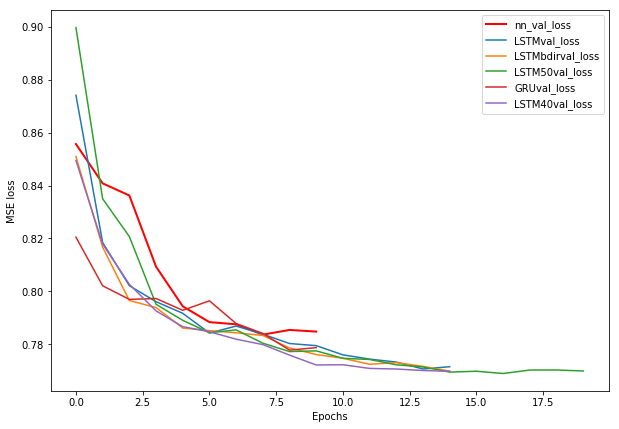

In [68]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(nn_history.history['val_loss'], label = 'nn_val_loss', color = 'r', linewidth = 2)
plt.plot(LSTM_history.history['val_loss'], label = 'LSTMval_loss')
plt.plot(LSTMbdir_history.history['val_loss'], label = 'LSTMbdirval_loss')
plt.plot(LSTM50_history.history['val_loss'], label = 'LSTM50val_loss')
plt.plot(GRUbdir_history.history['val_loss'], label = 'GRUval_loss')
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'LSTM40val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

In [17]:
# Bidirectional GRU model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = GRU(40)(x)
x_bwd = GRU(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
GRU40_bdir = Model([user_input, movie_input], x)
GRU40_bdir.compile(Adam(0.001), loss='mse')
GRU40bdir_history = GRU40_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 15s - loss: 2.3134 - val_loss: 0.8706
Epoch 2/20
79845/79845 [==============================] - 15s - loss: 1.2578 - val_loss: 0.8248
Epoch 3/20
79845/79845 [==============================] - 15s - loss: 1.1387 - val_loss: 0.8026
Epoch 4/20
79845/79845 [==============================] - 15s - loss: 1.0141 - val_loss: 0.7967
Epoch 5/20
79845/79845 [==============================] - 15s - loss: 0.9205 - val_loss: 0.7981
Epoch 6/20
79845/79845 [==============================] - 15s - loss: 0.8545 - val_loss: 0.7866
Epoch 7/20
79845/79845 [==============================] - 15s - loss: 0.8025 - val_loss: 0.7880
Epoch 8/20
79845/79845 [==============================] - 15s - loss: 0.7783 - val_loss: 0.7878
Epoch 9/20
79845/79845 [==============================] - 15s - loss: 0.7617 - val_loss: 0.7873
Epoch 10/20
79845/79845 [==============================] - 15s - loss: 0.7530 - val_lo

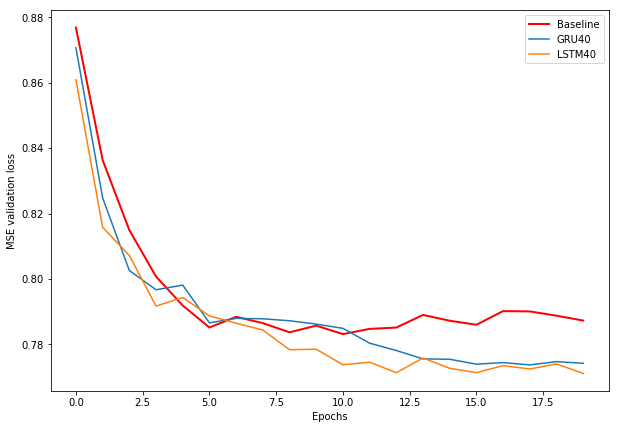

In [19]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(BASELINE.history['val_loss'], label = 'Baseline', color = 'r', linewidth = 2)
plt.plot(GRU40bdir_history.history['val_loss'], label = 'GRU40')
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'LSTM40')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

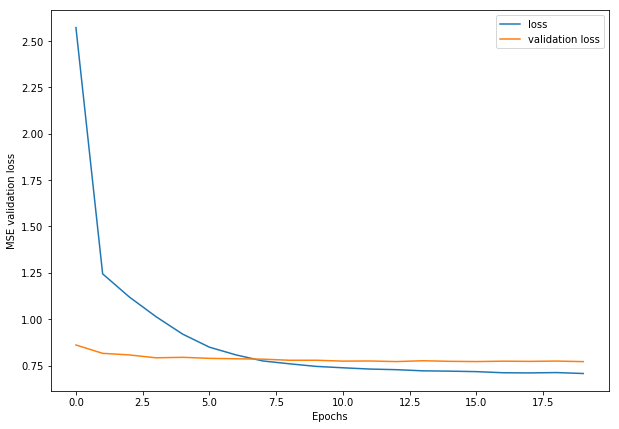

In [20]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(LSTM40bdir_history.history['loss'], label = 'loss')
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

So we're clearly still underfitting. Let's try further reducing the number of nodes (since they're effectively being doubled by the bidirectionality of the network)

In [21]:
# Bidirectional LSTM model

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(30)(x)
x_bwd = LSTM(30, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM30_bdir = Model([user_input, movie_input], x)
LSTM30_bdir.compile(Adam(0.001), loss='mse')
LSTM30bdir_history = LSTM30_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 18s - loss: 2.7604 - val_loss: 0.8641
Epoch 2/20
79845/79845 [==============================] - 18s - loss: 1.3429 - val_loss: 0.8262
Epoch 3/20
79845/79845 [==============================] - 18s - loss: 1.1800 - val_loss: 0.8043
Epoch 4/20
79845/79845 [==============================] - 18s - loss: 1.0436 - val_loss: 0.7975
Epoch 5/20
79845/79845 [==============================] - 18s - loss: 0.9252 - val_loss: 0.7941
Epoch 6/20
79845/79845 [==============================] - 18s - loss: 0.8425 - val_loss: 0.7873
Epoch 7/20
79845/79845 [==============================] - 18s - loss: 0.8009 - val_loss: 0.7859
Epoch 8/20
79845/79845 [==============================] - 18s - loss: 0.7742 - val_loss: 0.7835
Epoch 9/20
79845/79845 [==============================] - 18s - loss: 0.7575 - val_loss: 0.7826
Epoch 10/20
79845/79845 [==============================] - 18s - loss: 0.7511 - val_lo

In [22]:
# Bidirectional LSTM model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(35)(x)
x_bwd = LSTM(35, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM35_bdir = Model([user_input, movie_input], x)
LSTM35_bdir.compile(Adam(0.001), loss='mse')
LSTM35bdir_history = LSTM35_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 19s - loss: 2.6535 - val_loss: 0.8701
Epoch 2/20
79845/79845 [==============================] - 19s - loss: 1.2809 - val_loss: 0.8267
Epoch 3/20
79845/79845 [==============================] - 19s - loss: 1.1478 - val_loss: 0.8051
Epoch 4/20
79845/79845 [==============================] - 19s - loss: 1.0233 - val_loss: 0.7946
Epoch 5/20
79845/79845 [==============================] - 19s - loss: 0.9288 - val_loss: 0.7934
Epoch 6/20
79845/79845 [==============================] - 19s - loss: 0.8495 - val_loss: 0.7895
Epoch 7/20
79845/79845 [==============================] - 19s - loss: 0.8029 - val_loss: 0.7881
Epoch 8/20
79845/79845 [==============================] - 19s - loss: 0.7764 - val_loss: 0.7840
Epoch 9/20
79845/79845 [==============================] - 19s - loss: 0.7574 - val_loss: 0.7834
Epoch 10/20
79845/79845 [==============================] - 19s - loss: 0.7499 - val_lo

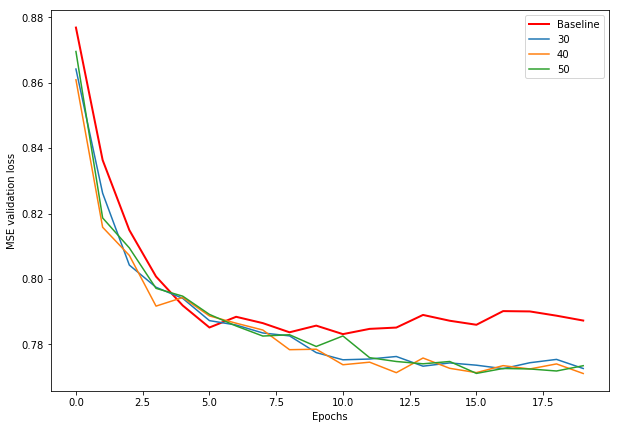

In [29]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(BASELINE.history['val_loss'], label = 'Baseline', color = 'r', linewidth = 2)
plt.plot(LSTM30bdir_history.history['val_loss'], label = '30')
plt.plot(LSTM40bdir_history.history['val_loss'], label = '40')
plt.plot(LSTM50_history.history['val_loss'], label = '50')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

In [30]:
# Bidirectional LSTM model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.8)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.8)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM40_D08 = Model([user_input, movie_input], x)
LSTM40_D08.compile(Adam(0.001), loss='mse')
LSTM40D08_history = LSTM40_D08.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 19s - loss: 2.7534 - val_loss: 0.8875
Epoch 2/20
79845/79845 [==============================] - 19s - loss: 1.3907 - val_loss: 0.8472
Epoch 3/20
79845/79845 [==============================] - 19s - loss: 1.2220 - val_loss: 0.8222
Epoch 4/20
79845/79845 [==============================] - 19s - loss: 1.0718 - val_loss: 0.8042
Epoch 5/20
79845/79845 [==============================] - 19s - loss: 0.9485 - val_loss: 0.7964
Epoch 6/20
79845/79845 [==============================] - 19s - loss: 0.8666 - val_loss: 0.7902
Epoch 7/20
79845/79845 [==============================] - 19s - loss: 0.8212 - val_loss: 0.7890
Epoch 8/20
79845/79845 [==============================] - 19s - loss: 0.7936 - val_loss: 0.7853
Epoch 9/20
79845/79845 [==============================] - 19s - loss: 0.7801 - val_loss: 0.7845
Epoch 10/20
79845/79845 [==============================] - 19s - loss: 0.7695 - val_lo

In [31]:
# Bidirectional LSTM model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.7)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.7)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM40_D07 = Model([user_input, movie_input], x)
LSTM40_D07.compile(Adam(0.001), loss='mse')
LSTM40D07_history = LSTM40_D07.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 20s - loss: 2.3931 - val_loss: 0.8349
Epoch 2/20
79845/79845 [==============================] - 20s - loss: 1.1504 - val_loss: 0.8121
Epoch 3/20
79845/79845 [==============================] - 20s - loss: 1.0469 - val_loss: 0.7966
Epoch 4/20
79845/79845 [==============================] - 20s - loss: 0.9636 - val_loss: 0.7950
Epoch 5/20
79845/79845 [==============================] - 20s - loss: 0.8968 - val_loss: 0.7884
Epoch 6/20
79845/79845 [==============================] - 20s - loss: 0.8331 - val_loss: 0.7873
Epoch 7/20
79845/79845 [==============================] - 20s - loss: 0.7939 - val_loss: 0.7838
Epoch 8/20
79845/79845 [==============================] - 20s - loss: 0.7674 - val_loss: 0.7808
Epoch 9/20
79845/79845 [==============================] - 19s - loss: 0.7446 - val_loss: 0.7755
Epoch 10/20
79845/79845 [==============================] - 20s - loss: 0.7307 - val_lo

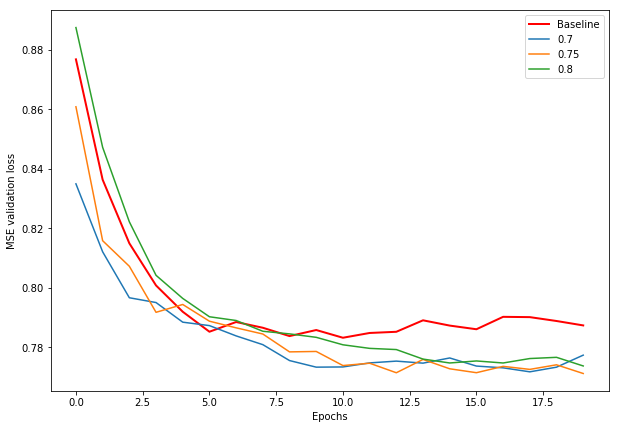

In [33]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(BASELINE.history['val_loss'], label = 'Baseline', color = 'r', linewidth = 2)
plt.plot(LSTM40D07_history.history['val_loss'], label = '0.7')
plt.plot(LSTM40bdir_history.history['val_loss'], label = '0.75')
plt.plot(LSTM40D08_history.history['val_loss'], label = '0.8')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

In [34]:
# Bidirectional LSTM model 

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.8)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
LSTM40_difD = Model([user_input, movie_input], x)
LSTM40_difD.compile(Adam(0.001), loss='mse')
LSTM40difD_history = LSTM40_difD.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 19s - loss: 2.7040 - val_loss: 0.8755
Epoch 2/20
79845/79845 [==============================] - 19s - loss: 1.3494 - val_loss: 0.8273
Epoch 3/20
79845/79845 [==============================] - 19s - loss: 1.1938 - val_loss: 0.8158
Epoch 4/20
79845/79845 [==============================] - 19s - loss: 1.0464 - val_loss: 0.8014
Epoch 5/20
79845/79845 [==============================] - 19s - loss: 0.9291 - val_loss: 0.7908
Epoch 6/20
79845/79845 [==============================] - 19s - loss: 0.8511 - val_loss: 0.7898
Epoch 7/20
79845/79845 [==============================] - 19s - loss: 0.8037 - val_loss: 0.7899
Epoch 8/20
79845/79845 [==============================] - 19s - loss: 0.7762 - val_loss: 0.7860
Epoch 9/20
79845/79845 [==============================] - 19s - loss: 0.7616 - val_loss: 0.7842
Epoch 10/20
79845/79845 [==============================] - 19s - loss: 0.7551 - val_lo

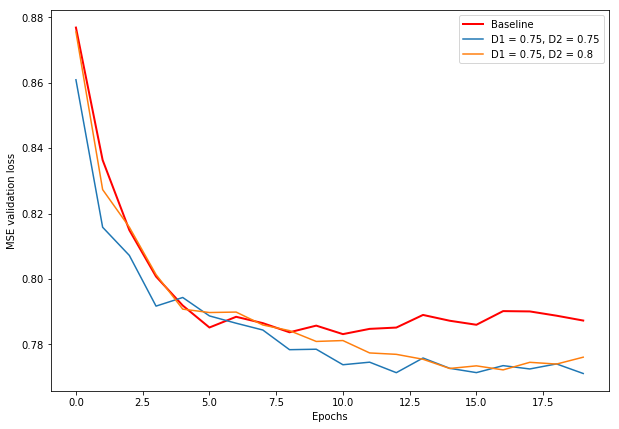

In [35]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(BASELINE.history['val_loss'], label = 'Baseline', color = 'r', linewidth = 2)
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'D1 = 0.75, D2 = 0.75')
plt.plot(LSTM40difD_history.history['val_loss'], label = 'D1 = 0.75, D2 = 0.8')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

In [39]:
# Bidirectional GRU model


user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = GRU(30)(x)
x_bwd = GRU(30, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
GRU30_bdir = Model([user_input, movie_input], x)
GRU30_bdir.compile(Adam(0.001), loss='mse')
GRU30_history = GRU30_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))


Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 15s - loss: 2.5601 - val_loss: 0.8815
Epoch 2/20
79845/79845 [==============================] - 16s - loss: 1.3685 - val_loss: 0.8396
Epoch 3/20
79845/79845 [==============================] - 16s - loss: 1.1946 - val_loss: 0.8136
Epoch 4/20
79845/79845 [==============================] - 16s - loss: 1.0437 - val_loss: 0.8081
Epoch 5/20
79845/79845 [==============================] - 16s - loss: 0.9197 - val_loss: 0.8046
Epoch 6/20
79845/79845 [==============================] - 15s - loss: 0.8493 - val_loss: 0.7928
Epoch 7/20
79845/79845 [==============================] - 15s - loss: 0.8016 - val_loss: 0.7911
Epoch 8/20
79845/79845 [==============================] - 15s - loss: 0.7774 - val_loss: 0.7872
Epoch 9/20
79845/79845 [==============================] - 15s - loss: 0.7650 - val_loss: 0.7835
Epoch 10/20
79845/79845 [==============================] - 15s - loss: 0.7515 - val_lo

In [41]:
# Bidirectional  GRU model with Batch Normalization


user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = GRU(25)(x)
x_bwd = GRU(25, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
GRU25_bdir = Model([user_input, movie_input], x)
GRU25_bdir.compile(Adam(0.001), loss='mse')
GRU25_history = GRU25_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))


Train on 79845 samples, validate on 20159 samples
Epoch 1/20
79845/79845 [==============================] - 16s - loss: 2.6736 - val_loss: 0.8723
Epoch 2/20
79845/79845 [==============================] - 16s - loss: 1.4446 - val_loss: 0.8436
Epoch 3/20
79845/79845 [==============================] - 16s - loss: 1.2333 - val_loss: 0.8120
Epoch 4/20
79845/79845 [==============================] - 16s - loss: 1.0518 - val_loss: 0.8082
Epoch 5/20
79845/79845 [==============================] - 16s - loss: 0.9244 - val_loss: 0.7932
Epoch 6/20
79845/79845 [==============================] - 16s - loss: 0.8416 - val_loss: 0.7897
Epoch 7/20
79845/79845 [==============================] - 16s - loss: 0.7977 - val_loss: 0.7900
Epoch 8/20
79845/79845 [==============================] - 16s - loss: 0.7750 - val_loss: 0.7870
Epoch 9/20
79845/79845 [==============================] - 16s - loss: 0.7624 - val_loss: 0.7854
Epoch 10/20
79845/79845 [==============================] - 16s - loss: 0.7551 - val_lo

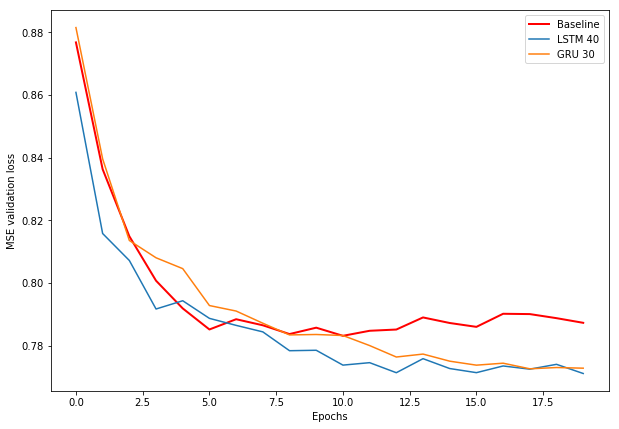

In [43]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(BASELINE.history['val_loss'], label = 'Baseline', color = 'r', linewidth = 2)
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'LSTM 40')
plt.plot(GRU30_history.history['val_loss'], label = 'GRU 30')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

In [10]:
# Bidirectional GRU model 


user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
x_fwd = GRU(30)(x)
x_bwd = GRU(30, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
x = Dense(1)(x)
GRU30_bdir = Model([user_input, movie_input], x)
GRU30_bdir.compile(Adam(0.001), loss='mse')
GRU30_history = GRU30_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80096 samples, validate on 19908 samples
Epoch 1/20
80096/80096 [==============================] - 15s - loss: 2.5334 - val_loss: 0.8915
Epoch 2/20
80096/80096 [==============================] - 15s - loss: 1.3670 - val_loss: 0.8519
Epoch 3/20
80096/80096 [==============================] - 15s - loss: 1.1888 - val_loss: 0.8275
Epoch 4/20
80096/80096 [==============================] - 14s - loss: 1.0375 - val_loss: 0.8191
Epoch 5/20
80096/80096 [==============================] - 14s - loss: 0.9222 - val_loss: 0.8040
Epoch 6/20
80096/80096 [==============================] - 14s - loss: 0.8419 - val_loss: 0.8001
Epoch 7/20
80096/80096 [==============================] - 15s - loss: 0.8003 - val_loss: 0.7986
Epoch 8/20
80096/80096 [==============================] - 15s - loss: 0.7760 - val_loss: 0.7953
Epoch 9/20
80096/80096 [==============================] - 15s - loss: 0.7613 - val_loss: 0.7976
Epoch 10/20
80096/80096 [==============================] - 15s - loss: 0.7493 - val_lo

In [11]:
# Bidirectional  GRU model with regularization


user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = GRU(30)(x)
x_bwd = GRU(30, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
x = Dropout(0.75)(x_bdir)
BatchNormalization()
x = Dense(1)(x)
GRU30bn_bdir = Model([user_input, movie_input], x)
GRU30bn_bdir.compile(Adam(0.001), loss='mse')
GRU30bn_history = GRU30bn_bdir.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=20, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80096 samples, validate on 19908 samples
Epoch 1/20
80096/80096 [==============================] - 15s - loss: 2.5360 - val_loss: 0.8993
Epoch 2/20
80096/80096 [==============================] - 15s - loss: 1.3538 - val_loss: 0.8439
Epoch 3/20
80096/80096 [==============================] - 15s - loss: 1.1821 - val_loss: 0.8197
Epoch 4/20
80096/80096 [==============================] - 15s - loss: 1.0363 - val_loss: 0.8076
Epoch 5/20
80096/80096 [==============================] - 15s - loss: 0.9145 - val_loss: 0.8053
Epoch 6/20
80096/80096 [==============================] - 15s - loss: 0.8407 - val_loss: 0.7984
Epoch 7/20
80096/80096 [==============================] - 15s - loss: 0.7977 - val_loss: 0.7992
Epoch 8/20
80096/80096 [==============================] - 15s - loss: 0.7744 - val_loss: 0.7951
Epoch 9/20
80096/80096 [==============================] - 15s - loss: 0.7600 - val_loss: 0.7955
Epoch 10/20
80096/80096 [==============================] - 15s - loss: 0.7523 - val_lo

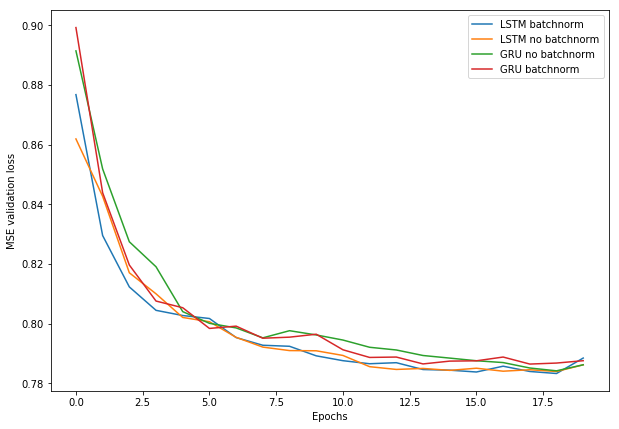

In [16]:
plt.clf()
plt.figure(figsize = (10,7))
plt.plot(LSTM40bdir_history.history['val_loss'], label = 'LSTM batchnorm')
plt.plot(LSTM40nbn_history.history['val_loss'], label = 'LSTM no batchnorm')
plt.plot(GRU30_history.history['val_loss'], label = 'GRU no batchnorm')
plt.plot(GRU30bn_history.history['val_loss'], label = 'GRU batchnorm')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE validation loss')
plt.show()

### Getting the outputs

In [62]:
# Best result

user_input = Input(shape=(1,), dtype='int64', name='user_input')
movie_input = Input(shape = (1,), dtype = 'int64', name = 'movie_input')
user_embed = Embedding(len(users), 50, input_length =1)(user_input)
movie_embed = Embedding(len(movies), 50, input_length =1)(movie_input)
x = merge([user_embed, movie_embed], mode='concat')

x = Dropout(0.75)(x)
BatchNormalization()
x_fwd = LSTM(40)(x)
x_bwd = LSTM(40, go_backwards = True)(x)
x_bdir = merge([x_fwd, x_bwd], mode = 'concat')
Activation_model = Model([user_input, movie_input], x_bdir)


In [68]:
for layer in zip(LSTM40_bdir.layers[:-2], Activation_model.layers):
    # the new weights are the second element in the tuple
    layer[1].set_weights([x for x in layer[0].get_weights()])

Activation_model.compile(Adam(0.001), loss='mse')

In [71]:
activations = Activation_model.predict([valid.userId, valid.movieId])

In [74]:
len(activations), len(valid.movieId)

(19908, 19908)

Saving the data, so that I can use it for visualizations

In [79]:
valid.to_csv('MOVIELENSvalid.csv')

In [80]:
np.save('activations.npy', activations)

In [17]:
X_50_iter5000 = np.load('data/MovieLens/X_50_iter5000.npy')